In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Outline:
1. EDA
    - Getting Familiar With The Data
    - Creating Test Set, Never Looking at It Again
    - In-Depth Visualization
    - Feature Engineering
2. Cleaning Data
3. Feature Scaling and Transformation
    - Custom Transformers
4. Transformation Pipelines
    - Pipeline Class
    - Recap on Full Preprocssing Pipeline
5. Selecting and Training a Model
    - Linear Regression
    - Decision Trees
    - Random Forests
    - Using Cross Validation
6. Fine Tuning: Intro
7. Test Set Evaluation


# 1. EDA

In [2]:
df = pd.read_csv('housing.csv')

### 1.1 Getting familiar with the data

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# 20,640 records. 10 Features for each record.
print(df.shape)
print(df.info())
# total_rooms and bedrooms and so on is "within a block". Not per house.
df.describe()

(20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


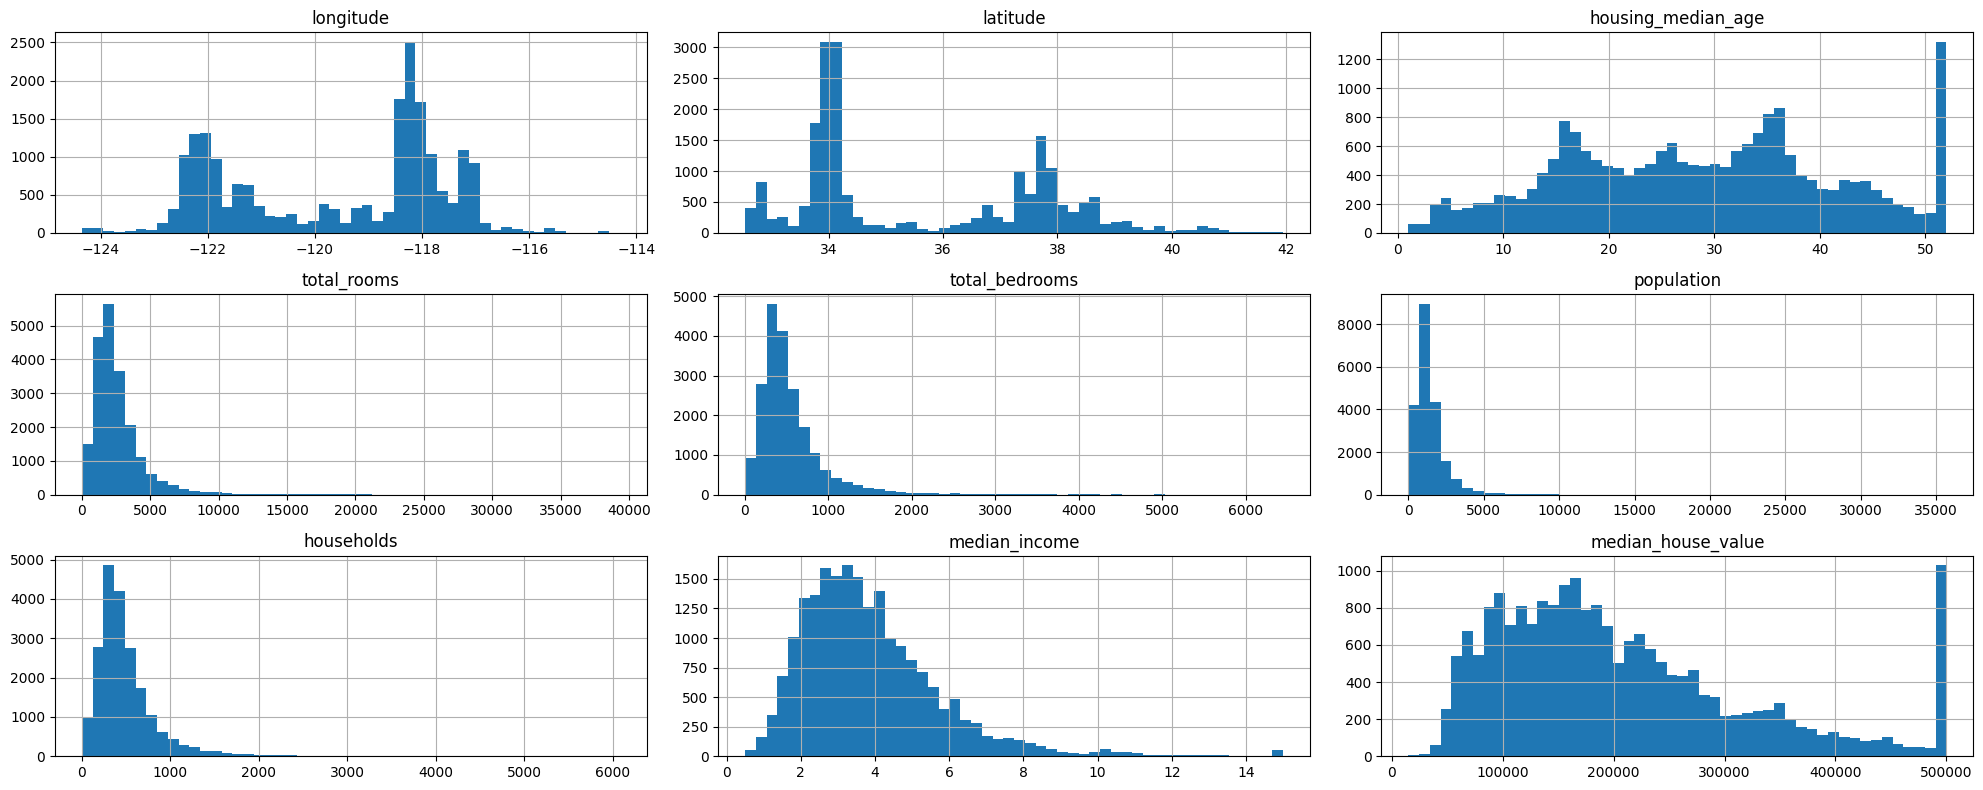

In [5]:
df.hist(figsize= (20,8), bins= 50)
plt.tight_layout()
plt.show()

### Notes (histograms):
1. median_income is in 10's of thousands of dollars. It is also capped to be between 0.5 and 15. So the data is preprocessed this way.
2. housing_median_age & median_house_value are also capped. Capped house values are a problem since those are our targets. To solve this:
    - ---> Find proper labels for block values that have been capped (difficult)
    - ---> Remove those blocks with capped price from the data.
3. The features clearly have very different ranges. So we will need feature scaling.
4. Histograms are skewed right. As we discussed, it is better for data to be normalized.

## 1.2 Create test set, never look at it again

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df['income_cat'] = pd.cut(df['median_income'], 
                          bins = [0,1.5,3,4.5,6,np.inf],
                          labels = [1,2,3,4, 5]
                          )

<Axes: xlabel='income_cat'>

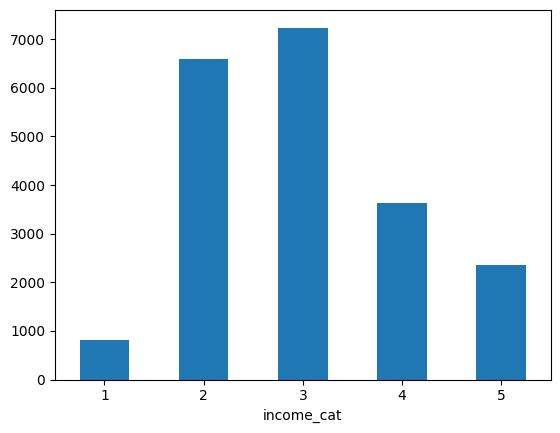

In [8]:
df['income_cat'].value_counts().sort_index().plot.bar(rot=0)

In [9]:
strat_train_set, strat_test_set = train_test_split(df,random_state=42, stratify=df['income_cat'], test_size=0.2)

In [10]:
#Drop housing cat we don't need it anymore
strat_train_set.drop(columns = 'income_cat', inplace=True)
strat_test_set.drop(columns = 'income_cat', inplace=True)

In [11]:
# This is a non-stratified split, which causes all null values to go to test set.
#train_set, test_set = train_test_split(df, random_state=42, test_size=0.2)

In [12]:
print(f"strat_train_set has shape {strat_train_set.shape}")
print(f"strat_test_set has shape {strat_test_set.shape}")

strat_train_set has shape (16512, 10)
strat_test_set has shape (4128, 10)


<hr>

### Notes (non-stratified data split):
1. This is purely random sampling, which is okay when data is large relative to num of feautures. If not however,<br>
    ---> we run a risk of sampling bias. Where samples are not an accurate representation of the full data.

<hr>

<hr>

### Side Note(strat_test_split):
1. Experts say median_income is a very important feature. Let's make sure the test split doesn't incur a sampling bias.
    - We can do this by stratified sampling split, also provided by sklearn.
    - First we need a stratified sample. Where dataset is divided into different subgroups, and we take a certain num from each group
<hr>

## 1.3 In-depth visualization and cleaning 

In [13]:
# Since we're going to play around alot with the data, lets make a copy to be able to go back to original set at any time
housing = strat_train_set.copy()


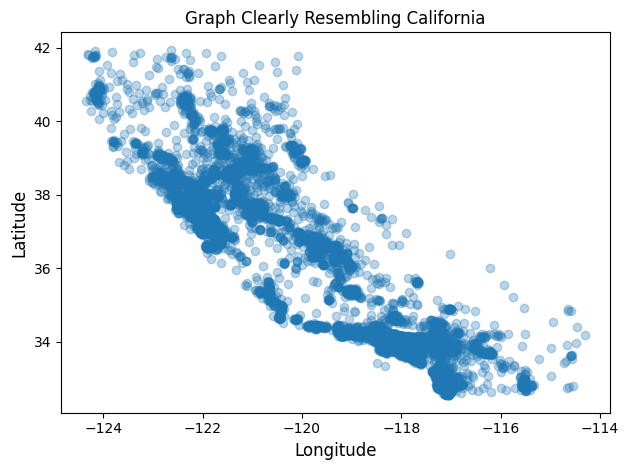

In [14]:
longitude = housing['longitude']
latitude = housing['latitude']
plt.scatter(longitude,latitude, alpha=0.3) #setting alpha emphasizes the more high-density areas
plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)
plt.title('Graph Clearly Resembling California')
plt.tight_layout()

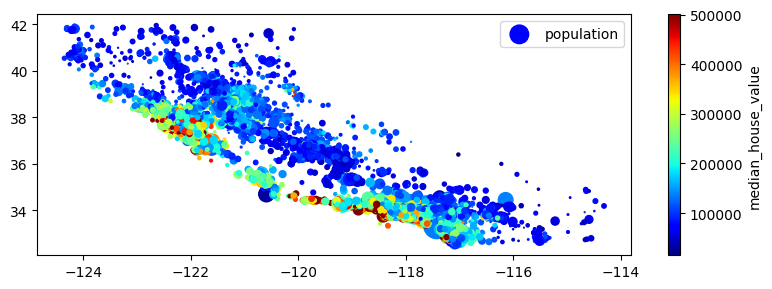

In [15]:
# let's compare with useful info
plt.figure(figsize=(8,3))
plt.scatter(longitude, latitude,
            s = housing['population']/100, #size of each scatter point represents population
            c = housing['median_house_value'], cmap= 'jet' , label = 'population',) #color can be visualized with cmap 
plt.colorbar(label ='median_house_value')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Another useful visualization is a correlation matrix, we will drop ocean proximity for now and deal with it later
housing_corr_matrix = housing.corr(numeric_only=True)
housing_corr_matrix


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


### Notes (correlation1):
1. Below cell is very important as it shows the correlation between certain features and the median house value. 
    - Obviously the greater the number the greater the effect of that feature on the house value
    - So median_income by far has the most effect on house value, then latitude not total_rooms. Although they're close
2. Another way to visualize that correlation using `scatter_matrix()` from pandas.plotting
3. CAREFUL: correlation matrix only shows linear relationship, eg: if relationship between a certain feature and house price is quadratic, it will be 0, even though they obviously affect each other

In [17]:
housing_corr_matrix['median_house_value'].sort_values()

latitude             -0.142673
longitude            -0.047466
population           -0.026882
total_bedrooms        0.047781
households            0.064590
housing_median_age    0.114146
total_rooms           0.135140
median_income         0.687151
median_house_value    1.000000
Name: median_house_value, dtype: float64

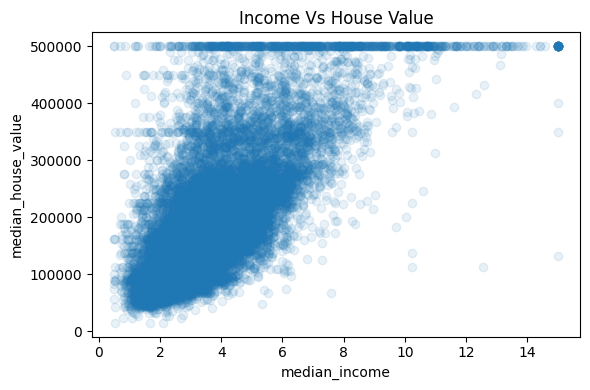

In [18]:
plt.figure(figsize=(6,4))
plt.scatter(housing['median_income'], housing['median_house_value'], alpha=0.1)
plt.xlabel('median_income')
plt.ylabel('median_house_value')
plt.title('Income Vs House Value')
plt.tight_layout()

### Notes (correlation2):
1. Correlation is strong as expected.
2. Price cap visible at 500K
3. Less visible horizontal lines at 450k,350k,220k...what do they mean?
    - They are data quirks: unexpected or unusual pattern in data
    - It does not make sense for a median_income of 2 and 10 to have the same house value of 300K
    - Maybe we can remove these points later so they don't mess up the algorithm, or maybe not.


## 1.3 A little feature engineering
- First, total_rooms is irrelevant since we're talking about per block not per house. 
    - Let's make a new feature called rooms_per_house
- Same for bedrooms. It's more useful to check out the ratio between bedrooms and total rooms.
    - New feature called bedrooms_ratio
- We can do the same for population. It's probably more relevant to get num of people per house, than per block right?
- Second, check out the correlation matrix again to see if you engineered good features or not!


In [19]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,0.182692,3.167241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN,6.658342,0.184696,2.023976
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND,5.571932,0.179977,3.363188
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN,4.110465,0.234795,2.662791
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN,6.297405,0.183835,2.411178


In [20]:
# GREAT, we engineered 3 new features with a much better correlation than the ones we had
housing_corr_matrix_engineered = housing.corr(numeric_only=True)
housing_corr_matrix_engineered['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
rooms_per_house       0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
people_per_house     -0.021991
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_ratio       -0.259952
Name: median_house_value, dtype: float64

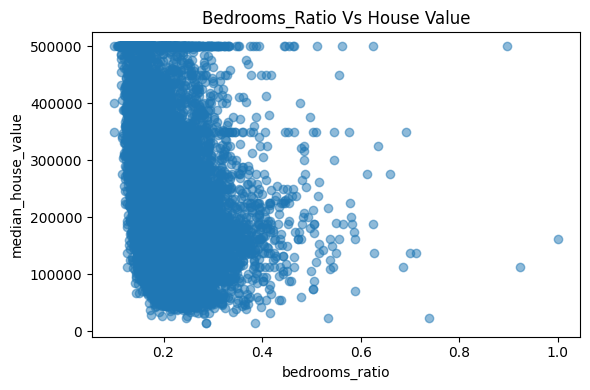

In [21]:
plt.figure(figsize=(6,4))
plt.scatter(housing['bedrooms_ratio'], housing['median_house_value'], alpha=0.5)
plt.xlabel('bedrooms_ratio')
plt.ylabel('median_house_value')
plt.title('Bedrooms_Ratio Vs House Value')
plt.tight_layout()

# 2. Clean the data

### Notes (cleaning): 
1. You should write functions when cleaning and preprocessing, for reusability even in later projects, as well as testing various combinations, will be shown later.
2. All we did above was play around with data to help with visualization. Now let's actually clean the data. Make a new copy to start fresh, and separate the input features from the target while we're at it.

In [22]:
housing = strat_train_set.drop(columns = 'median_house_value')
housing_labels = strat_train_set['median_house_value'].copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


### First let's handle the Null values in total_bedrooms. 3 Ways to Fix this:
- Get rid of all blocks with these null values
- Get rid of the total_bedrooms feature
- Set missing values to some number(0,mean,median..etc). This is called imputation, and it is generally most useful.

In [23]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [24]:
housing_num = housing.select_dtypes(include = [np.number]) # this line selects only numerical features
housing_num


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


### Note (Imputer):
- This imputer simply computes median of each feature and stores it in its statistics_ variable

In [25]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [26]:
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [27]:
# Now transform our feature to one with imputed values
X = imputer.transform(housing_num)
X # Problem is scikit-learn transform methods output numpy arrays, so we need to revert it back to dataframe.


array([[-1.2146e+02,  3.8520e+01,  2.9000e+01, ...,  2.2370e+03,
         7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00, ...,  2.0150e+03,
         7.6800e+02,  6.3373e+00],
       [-1.1904e+02,  3.5370e+01,  4.4000e+01, ...,  6.6700e+02,
         3.0000e+02,  2.8750e+00],
       ...,
       [-1.2272e+02,  3.8440e+01,  4.8000e+01, ...,  4.5800e+02,
         1.7200e+02,  3.1797e+00],
       [-1.2270e+02,  3.8310e+01,  1.4000e+01, ...,  1.2080e+03,
         5.0100e+02,  4.1964e+00],
       [-1.2214e+02,  3.9970e+01,  2.7000e+01, ...,  6.2500e+02,
         1.9700e+02,  3.1319e+00]])

In [28]:
imputer.get_feature_names_out() #this method gives the columns of the df

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [29]:
housing_df = pd.DataFrame(X, columns = housing_num.columns,
                 index = housing_num.index)

In [30]:
null_rows_idx = housing.isnull().any(axis=1)
housing_df[null_rows_idx].total_bedrooms.value_counts() #as ypu can see all total bedrooms have been filled with the median = 433

total_bedrooms
433.0    158
Name: count, dtype: int64

### Now let's deal with that ocean text feature


In [31]:
#Review of the dataframes we have to not get confused
print(housing.isnull().sum(), f"housing has shape {housing.shape}, has ocean proximity column")
print(housing_num.isnull().sum(), f"housing_num has shape {housing_num.shape}, excludes ocean proximity column")
print(housing_df.isnull().sum(), f"housing_tr has shape {housing_df.shape}, excludes ocean proximity and has no null values")


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64 housing has shape (16512, 9), has ocean proximity column
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
dtype: int64 housing_num has shape (16512, 8), excludes ocean proximity column
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64 housing_tr has shape (16512, 8), excludes ocean proximity and has no null values


In [32]:
#Quick side note on the difference between series and 1 col dataframe
housing_cat = housing[['ocean_proximity']]
print(type(housing['ocean_proximity']))
print(type(housing[['ocean_proximity']]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


### Use pd.get_dummies() function to one hot encode the ocean proximity column

In [33]:
df_1hot = pd.get_dummies(housing_cat).astype(int)

### Or use OneHotEncoder from scikit learn

In [34]:
housing_cat

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
...,...
15174,<1H OCEAN
12661,INLAND
19263,<1H OCEAN
19140,<1H OCEAN


In [35]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [36]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [37]:
cat_encoder.transform(housing_cat)
print(cat_encoder.feature_names_in_) #Returns column name that it performed 1 hot encoding on
cat_encoder.get_feature_names_out() #Returns column names after transformation has been applied

['ocean_proximity']


array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [38]:
df_output = pd.DataFrame(housing_cat_1hot,
                         columns = cat_encoder.get_feature_names_out(),
                         index = housing.index)
housing.join(df_output)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,0.0,1.0,0.0,0.0,0.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,0.0,0.0,0.0,0.0,1.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND,0.0,1.0,0.0,0.0,0.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,0.0,0.0,0.0,0.0,1.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND,0.0,1.0,0.0,0.0,0.0
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN,1.0,0.0,0.0,0.0,0.0
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN,1.0,0.0,0.0,0.0,0.0


### Note (Recap on Sec 1,2)
- Visualized data and looked for correlations
- Created 3 new features
- Imputed null values in total_bedrooms with median
- Applied one hot encoding to be able to deal with the text feature ocean_proximity <br><br>
- We did them separately, we will merge everything later.

# 3. Feature Scaling and Transformation

### Notes (Sklearn Design)
- Scikit-Lean Design:
    1. Estimators: Any object that can estimate some parameters based on a dataset. Eg: SimpleImputer.
        - Estimation performed by .fit() method
    2. Transformers: Some estimators can "transform" a dataset. Generally relies on learned parameters.
        - Transformation performed by .transform() method
    3. Predictors: Some estimators, given a dataset, can make predictions.
- Remember, Never use fit() or fit_transform() on anything other than training set. Once you have a trained "estimator", you can then use transform() to apply it to any other set. Test set, validation...etc.

### Notes (Standard Scaling)
- Subtracts mean, then divided by standard deviation. So all values have stdev of 1.
- It does not restrict values to a specific range. (Msh shart -1 to 1 or 0 to 1 etc...)
- It is much less affected by outliers as compare to Min-max scaling(normalization).

In [39]:
housing_num.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750


In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing_num_std_scaled = scaler.fit_transform(housing_num)

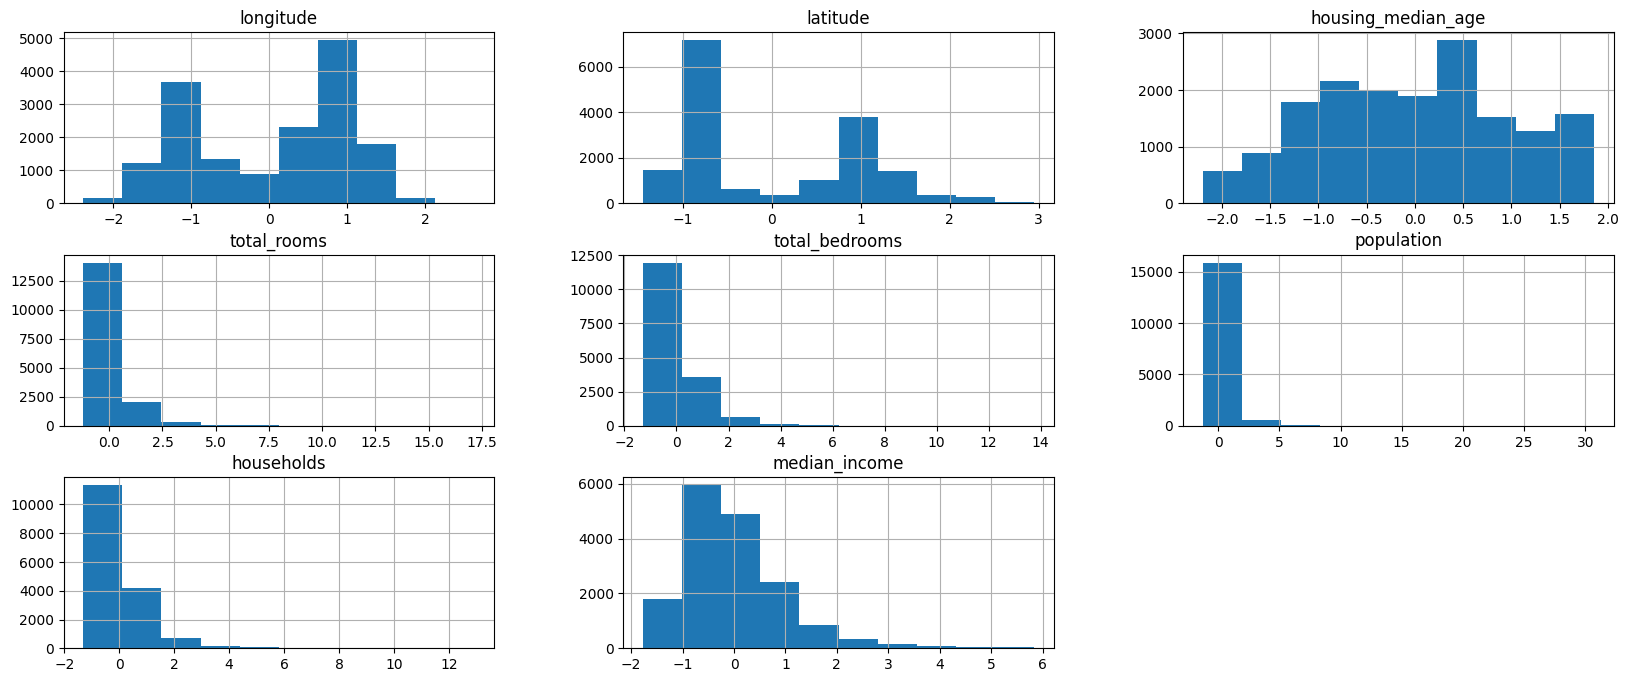

In [41]:
scaler.get_feature_names_out()
housing_num_std_scaled_df = pd.DataFrame(housing_num_std_scaled,
                                         columns = scaler.get_feature_names_out(),
                                         index = housing_num.index)
housing_num_std_scaled_df.hist(figsize=(20,8))
#housing_num.hist(figsize=(20,8))
plt.show()

### Notes (Scaling Heavy Tailed Features):
- When features have a heavy tail (values far from mean are not exponentially rare). StandardScaling (and minmax 3mtn) will squash most values to a small range which does not work well for the ML models.
- So we have to first make the features have a "normal" distribution or Symmetrical or gaussian. Can be done by:
    - For positive features, just taking the square root (or a power between 0 and 1.)
    - For really long tails, we can take the log of the feature.( May need to add + 1 to avoid computing log(0)).
- We may also need to transform the target feature, but be careful that now the model will predict the "scaled" target.
    - For example, we will predict log of the house value, instead of the house value itself. This is solvable by using TransformedTargetRegressor(). But that's for later.

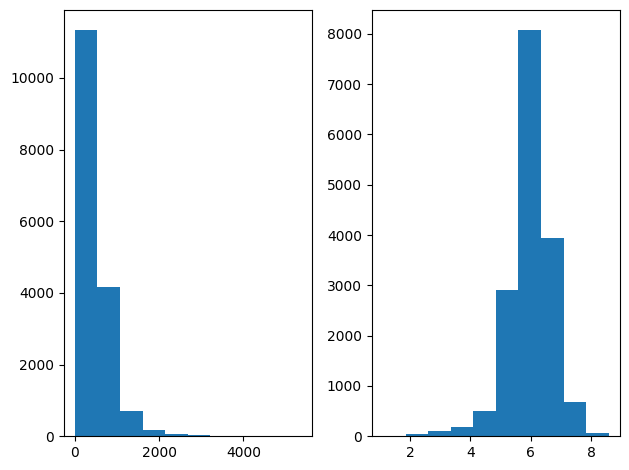

In [42]:
# Just showing the gaussian distribution, but we will implement it below in a diff way.
fig,ax = plt.subplots(1,2)
ax[0].hist(housing_num['households'])
ax[1].hist(np.log(housing_num['households'] + 1))
plt.tight_layout()
plt.show()

### Custom Transformers
- Although scikit provides many useful transformers, you may need to write your own to accomplish specific tasks.
- This can be done using the FunctionTransformer class, as shown below.
- Mn el akher the FunctionTransformer allows you to use the same style as scikit.

<Axes: >

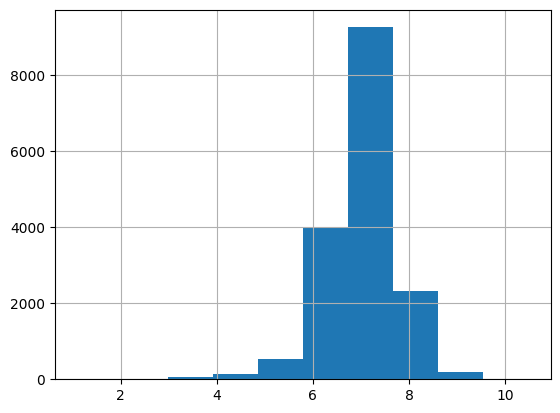

In [43]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func= np.exp)
log_pop = log_transformer.transform(housing_num['population'])
log_pop.hist()

# 4. Transformation Pipelines

### Note (IntroToPipeline)
- As seen, there are so many transformation steps, and they need to be done in the right order.
- To achieve this, we use the Pipeline class from scikit learn.

## 4.1 Pipeline Class:
- Takes a list of name/estimator pairs.
- Names must be unique, and estimators must be transformers, except for the last one which can be estimator, transformer, predictor.
- When you call fit() on pipeline, it just sequentially calls fit_transform() on all the transformers, till the final one where it just calls fit.
- Pipelines support indexing. Eg: pipeline[1] returns the 2nd estimator in the pipeline.

In [44]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])
housing_num_prepared = num_pipeline.fit_transform(housing_num)

In [45]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared,
                                       columns= num_pipeline.get_feature_names_out(),
                                       index = housing_num.index)
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752
...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374
12661,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509
19263,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475
19140,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261


### Note (ColumnTransformer)
- To use a single transformer to manage several pipelines/tranformations on same dataset, we use `ColumnTransformer`
- It requires a list of tuples where each tuple is (name, transformation/pipeline , list that transformer should be applied to)
- Ex: Below we want to create two pipelines. One for numerical data. One for Categorical Data

In [46]:
print(list(housing.select_dtypes(include = np.number)))
print(list(housing.select_dtypes(exclude=np.number)))

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
['ocean_proximity']


In [47]:
from sklearn.compose import ColumnTransformer

num_attributes = list(housing.select_dtypes(np.number))
cat_attributes = ['ocean_proximity']

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
     ('encoder', OneHotEncoder())
])

In [48]:
preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', cat_pipeline, cat_attributes)
])

In [49]:
housing_pipelined = preprocessing.fit_transform(housing)

pd.DataFrame(housing_pipelined,
             columns = preprocessing.get_feature_names_out(),
             index = housing.index)

,num__longitude,num__latitude,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,0.0,1.0,0.0,0.0,0.0
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,0.0,0.0,0.0,0.0,1.0
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374,1.0,0.0,0.0,0.0,0.0
12661,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509,0.0,1.0,0.0,0.0,0.0
19263,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475,1.0,0.0,0.0,0.0,0.0
19140,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261,1.0,0.0,0.0,0.0,0.0


## 4.3 Recap on Full Preprocessing Pipeline:
- Takes entire training dataset (housing)
- Applies each transformer to its appropriate column
- Concatenates the newly formed columns
- Returns a numpy array that we converted to a dataframe manually.

***Now let's apply that to ALL the data preprocessing we did above to make a new final pipeline.***
### Recap to what our pipeline should do:
1. Replace missing values in total_bedrooms with the median. <--Impute
2. Apply one hot encoding to ocean_proximity.
3. Feature engineering. Create 3 new features from our dataset. bedrooms_ratio, rooms_per_house, people_per_house. These are all ratios.
4. Replace features with long tails by their logarithm. 
5. Apply Standard Scaling to all numerical features

In [50]:
# Thinking process steps
# 1. Han3ml pipeline kbeer fe kaza pipeline or preprocessing step, then we need ColumnTransformer
# 2. First thing in ColumnTransformer is Creating 3 new features, 3shan we need the full dataset abl ma nel3ab feha to do so.
#   2.1. 1st feature is bedrooms_ratio
#       - Remember: ColumnTransformer takes (name, transformation, list of column names that transformer should be applied to)
#       - Let's create the ratio_transformer PIPELINE. Why pipeline? Because we also need to scale that feature, and impute missing values for total_bedrooms
#         but we won't need to apply log
#       - make_pipeline takes list of transformers. 1) SimpleImputer. 2) FunctionTransformer. 3) StandardScaler
#       - ehna 3ayzeen n3ml divide le 2 columns fel functiontransformer. So let's create function called column_division.
#       - Recap: 0- FunctionTransformer applies the column_division function when ratio_pipeline is called.
#                1- ratio_pipeline() is a transformer function applied in ColumnTransformer
#                2- ColumnTransformer is applied on my housing dataset, specifically on the total_bedrooms and total_rooms columns.
#   2.2. 2nd Feature is rooms_per_house, we will do the same. 3ayz akhlay column 0 howa el total_rooms and column 1 howa el households. Same for people_per_house
# 3. Replace features that have long tail with log. Let's make a pipeline for that as well.
#    3.1. Features to replace are bedrooms,rooms,population,households,median income.
#    3.2. Also need SimpleImputer, FunctionTransformer. StandardScaler()
# 4. Finally we need to apply one hot encoding to ocean_proximity.
#    4.1. We will use the cat_pipeline that we already made above. Just copy and paste it.
# 5. Use remainder property of ColumnTransformer to decide what to do with remaining columns in dataset that haven't been transformed.
#    5.1. make a default_pipeline for any columns that have not been transformed. Apply simpleimputer and standardscaler to them.



from sklearn.pipeline import make_pipeline

def column_division(X):
    return X[:,[0]] / X[:,[1]]
    

def ratio_name(function_transformer,feature_names_in):
    return ['ratio']

def ratio_pipeline():
    return make_pipeline(SimpleImputer(strategy='median'),
                   FunctionTransformer(column_division, feature_names_out=ratio_name),
                   StandardScaler()
    )

    
log_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                              FunctionTransformer(np.log, feature_names_out='one-to-one'),
                              StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder()
)

default_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing = ColumnTransformer(
    [
        ('bedrooms_ratio', ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
        ('rooms_per_house', ratio_pipeline(), ['total_rooms', 'households']),
        ('people_per_house', ratio_pipeline(), ['population', 'households']),
        ('log_feat', log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
        ('one_hot', cat_pipeline, ['ocean_proximity'])
      
    ], 
    remainder= default_pipeline)

housing_finished = preprocessing.fit_transform(housing)
df_housing_finished = pd.DataFrame(housing_finished,
                                   columns = preprocessing.get_feature_names_out(),
                                   index = housing.index)

In [51]:
preprocessing.get_feature_names_out()

array(['bedrooms_ratio__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log_feat__total_bedrooms',
       'log_feat__total_rooms', 'log_feat__population',
       'log_feat__households', 'log_feat__median_income',
       'one_hot__ocean_proximity_<1H OCEAN',
       'one_hot__ocean_proximity_INLAND',
       'one_hot__ocean_proximity_ISLAND',
       'one_hot__ocean_proximity_NEAR BAY',
       'one_hot__ocean_proximity_NEAR OCEAN', 'remainder__longitude',
       'remainder__latitude', 'remainder__housing_median_age'],
      dtype=object)

In [52]:
df_housing_finished

,bedrooms_ratio__ratio,rooms_per_house__ratio,people_per_house__ratio,log_feat__total_bedrooms,log_feat__total_rooms,log_feat__population,log_feat__households,log_feat__median_income,one_hot__ocean_proximity_<1H OCEAN,one_hot__ocean_proximity_INLAND,one_hot__ocean_proximity_ISLAND,one_hot__ocean_proximity_NEAR BAY,one_hot__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age
12655,-0.121122,0.017395,0.006223,0.873403,0.852032,0.938249,0.797843,-0.998832,0.0,1.0,0.0,0.0,0.0,-0.941350,1.347438,0.027564
15502,-0.810867,0.569256,-0.040811,0.970407,1.277433,0.796538,0.913214,1.277742,0.0,0.0,0.0,0.0,1.0,1.171782,-1.192440,-1.722018
2908,-0.338273,-0.018024,-0.075371,-0.430559,-0.317644,-0.702499,-0.375177,-0.403837,0.0,1.0,0.0,0.0,0.0,0.267581,-0.125972,1.220460
14053,0.961205,-0.595140,-0.106803,0.281063,-0.118663,-0.299288,0.277558,-0.947769,0.0,0.0,0.0,0.0,1.0,1.221738,-1.351474,-0.370069
20496,-0.474513,0.251241,0.006109,0.583337,0.730040,0.671139,0.528397,0.547635,1.0,0.0,0.0,0.0,0.0,0.437431,-0.635818,-0.131489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-0.443846,0.466353,-0.092580,1.473719,1.579483,0.803919,1.276380,0.811447,1.0,0.0,0.0,0.0,0.0,1.251711,-1.220505,-1.165333
12661,-0.516065,0.050362,0.023024,1.672897,1.807457,1.964650,1.753694,-0.449539,0.0,1.0,0.0,0.0,0.0,-0.921368,1.342761,-1.085806
19263,0.322869,-0.509240,-0.037436,-1.293050,-1.427119,-1.212202,-1.137635,-0.189525,1.0,0.0,0.0,0.0,0.0,-1.570794,1.310018,1.538566
19140,-0.457023,0.328149,-0.059156,0.434515,0.577261,0.102799,0.327708,0.400730,1.0,0.0,0.0,0.0,0.0,-1.560803,1.249211,-1.165333


***Clean up column names of the df***

# 5. Finally! Select and Train a Model.

In [53]:
from sklearn.linear_model import LinearRegression
# Remember. housing is the training set, and housing_labels is the targets of the training set.
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

c:\Users\Dell\miniconda3\envs\workshop_env\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name a...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('linearregression', LinearRegression())])

In [54]:
housing_predictions = lin_reg.predict(housing)
print(housing_predictions)

#-------Convert Array from .predict() to dataframe------------
df_housing_predictions = pd.DataFrame(housing_predictions,
                                      index = housing_labels.index)
#-------------------------------------------------------------

display(df_housing_predictions)
display(housing_labels.to_frame())

[ 75904.57579571 296127.6348477  183420.65391634 ... 238429.01871311
 263126.23566293  98804.88527171]


,0
12655,75904.575796
15502,296127.634848
2908,183420.653916
14053,206653.595035
20496,257587.027533
...,...
15174,298682.025869
12661,91223.852293
19263,238429.018713
19140,263126.235663


,median_house_value
12655,72100.0
15502,279600.0
2908,82700.0
14053,112500.0
20496,238300.0
...,...
15174,268500.0
12661,90400.0
19263,140400.0
19140,258100.0


In [55]:
from sklearn.metrics import root_mean_squared_error

round(root_mean_squared_error(housing_predictions, housing_labels),-3) # You get error of ~ $70K. Elhamdullah.

np.float64(71000.0)

## 5.2. Let's Try Other Models

In [56]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor())
tree_reg.fit(housing, housing_labels)

c:\Users\Dell\miniconda3\envs\workshop_env\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name a...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

### Note (Overfitting Example)
- We just trained the model on the training set, then predicted using the training set. Error is 0. Which is impossible.

In [57]:
housing_predictions_tree = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions_tree)
tree_rmse

np.float64(0.0)

## 5.3. Using Cross Validation
- cross_val_score does the following:
    - Randomly splits training set into 10 nonoverlapping sets. Called Folds.
    - Uses 9 folds for training, and 1 for evaluation(testing). Repeats 10 times.
    - Outputs array containing the 10 evaluation scores.
    - So it already does the .fit() and .predict() part, that's why it needs the tree_reg pipeline.

In [58]:
from sklearn.model_selection import cross_val_score
tree_rmse = -cross_val_score(tree_reg,housing,housing_labels,
                             scoring = 'neg_root_mean_squared_error',
                             cv = 10)
tree_rmse

array([72704.80673045, 70703.86727912, 69382.75976727, 71001.19183647,
       70079.32575851, 77965.1119513 , 69518.63642204, 72667.9974438 ,
       68310.39834123, 70697.80094048])

In [59]:
pd.Series(tree_rmse).describe()

count       10.000000
mean     71303.189647
std       2715.237841
min      68310.398341
25%      69658.808756
50%      70700.834110
75%      72251.296042
max      77965.111951
dtype: float64

### Random Forests
- They basically train many decision trees on random subsets of the features. Such models are called ensembles. They usually boost performance of underlying model.

In [60]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forest_rmse = -cross_val_score(forest_reg,housing,housing_labels,
                               scoring='neg_root_mean_squared_error',
                               cv = 5)

c:\Users\Dell\miniconda3\envs\workshop_env\lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dell\miniconda3\envs\workshop_env\lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
  File "c:\Users\Dell\miniconda3\envs\workshop_env\lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "c:\Users\Dell\miniconda3\envs\workshop_env\lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "c:\Users\Dell\miniconda3\envs\workshop_env\lib\site-packages\sklearn\utils\_response.py", line 239, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
  File "c:\Users\Dell\miniconda3\envs\workshop_env\lib\site-packages\sklearn\pipeline.py", line 600, in

In [61]:
print(forest_rmse)
pd.Series(forest_rmse).describe()

#Very good, we went down from 70K off to 50K off!

[           nan 49573.80843875 49940.87440267 51549.84051563
 51633.82988057]


count        4.000000
mean     50674.588309
std       1070.243467
min      49573.808439
25%      49849.107912
50%      50745.357459
75%      51570.837857
max      51633.829881
dtype: float64

# 6. Fine-Tuning.
- This is where the theoretical knowledge of the models matters.
- GridSearchCV, RandomizedSearchCV
- Hyperparameter tuning is a process of finding the best combination of hyperparameters for both preprocessing pipelines and models that results in the best score. It looks like this, but we won't run the following code.
<hr>

```text

from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

```
<hr>

# 7. Test Set Evaluation 

In [62]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,162500.0,<1H OCEAN
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,204600.0,<1H OCEAN
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,159700.0,<1H OCEAN
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,184000.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
12182,-117.29,33.72,19.0,2248.0,427.0,1207.0,368.0,2.8170,110000.0,<1H OCEAN
7275,-118.24,33.99,33.0,885.0,294.0,1270.0,282.0,2.1615,118800.0,<1H OCEAN
17223,-119.72,34.44,43.0,1781.0,342.0,663.0,358.0,4.7000,293800.0,<1H OCEAN
10786,-117.91,33.63,30.0,2071.0,412.0,1081.0,412.0,4.9125,335700.0,<1H OCEAN


In [63]:
X_test = strat_test_set.drop(columns = 'median_house_value')
y_test = strat_test_set['median_house_value'].copy()

In [64]:
final_model = forest_reg.fit(housing,housing_labels)
final_predictions = final_model.predict(X_test)

In [65]:
final_model

c:\Users\Dell\miniconda3\envs\workshop_env\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name a...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('one_hot',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [66]:
final_rmse = root_mean_squared_error(y_test, final_predictions)
print(f"Final RMSE to our best model is ${round(final_rmse)}")

Final RMSE to our best model is $48310
